In [1]:
!pip install timm

In [2]:
import timm

# Загрузка предобученной модели GhostNet
model = timm.create_model('ghostnet_100', pretrained=True)

# Вывод архитектуры
print(model)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/20.9M [00:00<?, ?B/s]

GhostNet(
  (conv_stem): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (blocks): Sequential(
    (0): Sequential(
      (0): GhostBottleneck(
        (ghost1): GhostModule(
          (primary_conv): Sequential(
            (0): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (cheap_operation): Sequential(
            (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=8, bias=False)
            (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
        )
        (ghost2): GhostModule(
          (primary_conv): Sequential(
            (0): Conv2d(16, 8, kernel_size=(1, 1)

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [6]:
class GhostModule(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=1, ratio=2, dw_size=3, stride=1, relu=True):
        super(GhostModule, self).__init__()
        self.out_channels = out_channels
        init_channels = int(out_channels / ratio)
        new_channels = init_channels * (ratio - 1)

        # Базовые каналы
        primary_layers = [
            nn.Conv2d(in_channels, init_channels, kernel_size, stride, kernel_size // 2, bias=False),
            nn.BatchNorm2d(init_channels)
        ]
        if relu:
            primary_layers.append(nn.ReLU(inplace=True))
        self.primary_conv = nn.Sequential(*primary_layers)

        # Призрачные каналы
        ghost_layers = [
            nn.Conv2d(init_channels, new_channels, dw_size, 1, dw_size // 2, groups=init_channels, bias=False),
            nn.BatchNorm2d(new_channels)
        ]
        if relu:
            ghost_layers.append(nn.ReLU(inplace=True))
        self.ghost_conv = nn.Sequential(*ghost_layers)

    def forward(self, x):
        x1 = self.primary_conv(x)
        x2 = self.ghost_conv(x1)
        out = torch.cat([x1, x2], dim=1)
        return out[:, :self.out_channels, :, :]

In [7]:
class GhostBottleneck(nn.Module):
    def __init__(self, in_channels, mid_channels, out_channels, dw_kernel_size=3, stride=1):
        super(GhostBottleneck, self).__init__()
        self.ghost1 = GhostModule(in_channels, mid_channels, kernel_size=1, relu=True)

        self.dw_conv = nn.Sequential() if stride == 1 else nn.Sequential(
            nn.Conv2d(mid_channels, mid_channels, dw_kernel_size, stride=stride,
                      padding=(dw_kernel_size - 1) // 2, groups=mid_channels, bias=False),
            nn.BatchNorm2d(mid_channels)
        )

        self.ghost2 = GhostModule(mid_channels, out_channels, kernel_size=1, relu=False)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, in_channels, dw_kernel_size, stride=stride,
                          padding=(dw_kernel_size - 1) // 2, groups=in_channels, bias=False),
                nn.BatchNorm2d(in_channels),
                nn.Conv2d(in_channels, out_channels, 1, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = x
        x = self.ghost1(x)
        x = self.dw_conv(x)
        x = self.ghost2(x)
        return x + self.shortcut(residual)



In [8]:
class GhostNet(nn.Module):
    def __init__(self, num_classes=10, width_mult=1.0):
        super(GhostNet, self).__init__()
        self.conv_stem = nn.Sequential(
            nn.Conv2d(3, int(16 * width_mult), kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(int(16 * width_mult)),
            nn.ReLU(inplace=True)
        )
        self.blocks = nn.Sequential(
            GhostBottleneck(int(16 * width_mult), int(16 * width_mult), int(16 * width_mult), stride=1),
            GhostBottleneck(int(16 * width_mult), int(32 * width_mult), int(32 * width_mult), stride=2),
            GhostBottleneck(int(32 * width_mult), int(32 * width_mult), int(32 * width_mult), stride=1),
            GhostBottleneck(int(32 * width_mult), int(64 * width_mult), int(64 * width_mult), stride=2),
            GhostBottleneck(int(64 * width_mult), int(64 * width_mult), int(64 * width_mult), stride=1),
            GhostBottleneck(int(64 * width_mult), int(128 * width_mult), int(128 * width_mult), stride=2),
            GhostBottleneck(int(128 * width_mult), int(128 * width_mult), int(128 * width_mult), stride=1),
        )
        final_channels = int(128 * width_mult)
        self.final_conv = nn.Sequential(
            nn.Conv2d(final_channels, int(1024 * width_mult), 1, bias=False),
            nn.BatchNorm2d(int(1024 * width_mult)),
            nn.ReLU(inplace=True)
        )
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Linear(int(1024 * width_mult), num_classes)

    def forward(self, x):
        x = self.conv_stem(x)
        x = self.blocks(x)
        x = self.final_conv(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x



In [ ]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)



100%|██████████| 170M/170M [00:04<00:00, 39.7MB/s]


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GhostNet(num_classes=10, width_mult=1.0).to(device)
print(model)

GhostNet(
  (conv_stem): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (blocks): Sequential(
    (0): GhostBottleneck(
      (ghost1): GhostModule(
        (primary_conv): Sequential(
          (0): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (ghost_conv): Sequential(
          (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=8, bias=False)
          (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
      )
      (dw_conv): Sequential()
      (ghost2): GhostModule(
        (primary_conv): Sequential(
          (0): Conv2d(16, 8, kernel_size=(1, 1), st

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GhostNet(num_classes=10, width_mult=1.0).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

num_epochs = 20

train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(trainloader)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0.0
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = outputs.max(1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)
    val_loss /= len(testloader)
    val_losses.append(val_loss)
    accuracy = 100. * correct / total
    val_accuracies.append(accuracy)

    scheduler.step()
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Accuracy: {accuracy:.2f}%')



Epoch 1/20, Train Loss: 1.6662, Val Loss: 1.4307, Accuracy: 51.46%
Epoch 2/20, Train Loss: 1.0923, Val Loss: 1.5219, Accuracy: 50.99%
Epoch 3/20, Train Loss: 0.8834, Val Loss: 1.0213, Accuracy: 64.84%
Epoch 4/20, Train Loss: 0.7882, Val Loss: 0.8359, Accuracy: 71.11%
Epoch 5/20, Train Loss: 0.7295, Val Loss: 0.7200, Accuracy: 75.29%
Epoch 6/20, Train Loss: 0.6980, Val Loss: 0.8382, Accuracy: 71.15%
Epoch 7/20, Train Loss: 0.6660, Val Loss: 0.7372, Accuracy: 74.50%
Epoch 8/20, Train Loss: 0.6396, Val Loss: 0.7542, Accuracy: 74.43%
Epoch 9/20, Train Loss: 0.6198, Val Loss: 0.7197, Accuracy: 75.95%
Epoch 10/20, Train Loss: 0.5939, Val Loss: 0.6782, Accuracy: 76.41%
Epoch 11/20, Train Loss: 0.5678, Val Loss: 0.6366, Accuracy: 78.02%
Epoch 12/20, Train Loss: 0.5412, Val Loss: 0.6992, Accuracy: 76.41%
Epoch 13/20, Train Loss: 0.5088, Val Loss: 0.5829, Accuracy: 79.66%
Epoch 14/20, Train Loss: 0.4773, Val Loss: 0.5174, Accuracy: 82.44%
Epoch 15/20, Train Loss: 0.4445, Val Loss: 0.4835, Accura

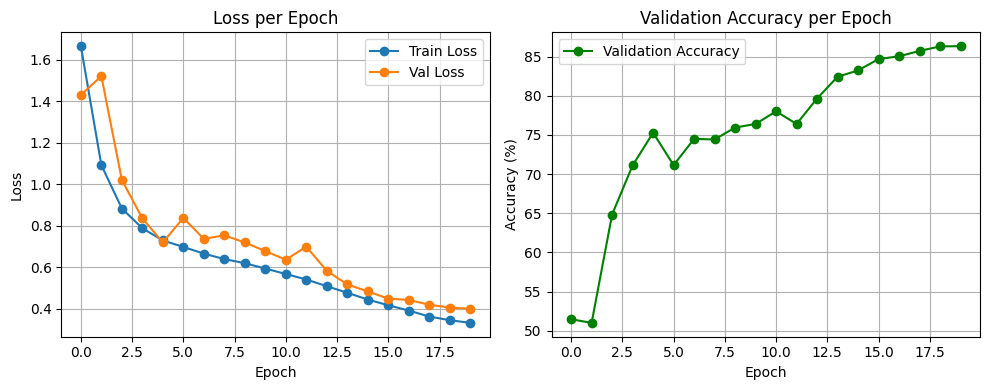

In [ ]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Val Loss', marker='o')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy', color='green', marker='o')
plt.title('Validation Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()